## lstm_models 

The functions in this module allow the application of a
LSTM (Long short-term memory) model for time series. There are separate 
functions to train and evaluate (separate the data in train and test 
datasets), train with all the data available and save the trained model, and make
forecasts.

Let's import the necessary packages:

In [6]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py')
from epigraphhub.data.get_data import get_cluster_data, get_georegion_data
from epigraphhub.models.lstm_models import *
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py/examples')

First, let's download a dataset from our platform to use as an example. To do this, we will use the function `get_cluster_data`. This function, by default, is configured to work well with the Switzerland covid data. In the example below, the result will be a data frame with datetime index. The columns are related to the time series of tests, cases, and hospitalizations in Geneva and your first and second order differences.

In [7]:
%%time
df = get_cluster_data('switzerland', ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'], ['GE'], vaccine = False)
df

CPU times: user 91.9 ms, sys: 14.5 ms, total: 106 ms
Wall time: 5.47 s


,test_GE,diff_test_GE,diff_2_test_GE,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE
datum,,,,,,,,,
2020-03-01,0.000000,0.000000,0.000000,1.428571,0.142857,0.142857,0.428571,0.000000,0.000000
2020-03-02,0.000000,0.000000,0.000000,1.714286,0.285714,0.428571,0.428571,0.000000,0.142857
2020-03-03,0.000000,0.000000,0.000000,1.714286,0.000000,0.285714,0.428571,0.000000,0.000000
2020-03-04,0.000000,0.000000,0.000000,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857
2020-03-05,0.000000,0.000000,0.000000,1.857143,0.142857,0.142857,0.857143,0.285714,0.428571
...,...,...,...,...,...,...,...,...,...
2022-05-06,859.000000,-8.142857,-16.142857,143.000000,-7.142857,-16.428571,4.285714,-0.285714,-0.285714
2022-05-07,858.000000,-1.000000,-9.142857,139.428571,-3.571429,-10.714286,3.428571,-0.857143,-1.142857
2022-05-08,856.285714,-1.714286,-2.714286,139.571429,0.142857,-3.428571,3.000000,-0.428571,-1.285714


### Function `build_model()`:

This function returns an LSTM model with three layers, the first is an LSTM layer, the second a bidirectional LSTM layer, and the last an LSTM layer. 

This function has the following parameters: 

* `hidden`: number of hidden nodes. Type = `int`. 
* `features`: Number of variables used to make the predictions. (Number of columns in the dataframe used in the next sections). Type = `int`;
* `predict_n`: Number of days that will be predicted. Type= `int`;
* `look_back`: Number of time-steps to look back before predicting. Type = `int`;
* `batch_size`: batch size for batch training. Type = `int`. Default = 1;

and the returns:
* `model`: the compiled LSTM model. 


**Important:** The same values used in `predict_n` and `look_back` in this function should be used in another function using the model created. 

In [8]:
hidden = 8 
model = build_model(
        hidden, df.shape[1], predict_n=14, look_back=21
    )

Compilation Time :  0.002228975296020508
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21, 9)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 21, 8)             576       
                                                                 
 dropout_3 (Dropout)         (None, 21, 8)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 8)            1088      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 21, 8)             0         
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                  

### Function  `traininig_eval_model()`:

To see the performance of an lstm model in our data, we can use the `train_eval_model` function. This function will split our data into train and test data and return a data frame with predicted values, predicted confidence intervals, and target values. 

The return of this function is a pandas DataFrame with the target values and the predictions. The dataframe has the following columns: `target`, with the values used to train and test the model, 	`lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, `train_size`, with the number  of target observations used to train the model, and a datetime index.

This function has the following parameters: 

* `model`:A compiled LSTM model. 
* `target_name`: Name of the target column, this column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `split`: Determines which percentage of the data will be used to train the model. Type = `float`. Default = 0.75;
* `predict_n`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `look_back`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14; 
* `batch`: . batch size for batch training. Type: `int`. Default = 1. 
* `epochs`: Number of epochs to train the model. Type: `int`. Default = 100. 
* `save`: If True, the trained model will be saved. Type: `boolean`. Default = True. 
* `path`: The path where the trained model will be saved. Type: `string`. Default = None. 
* `label`: The name used to save the trained model. The filename of the trained model is `{label}_{epochs}.h5`. Type: `string`. Default = `train_eval_region_name`; 
* `uncertainty`: If True, the confidence interval of the predictions is returned. Type: `boolean.` Default = True.

and the returns:
* `df_pred`: DataFrame with the target values and the predictions. The data frame has the following columns: `target`, with the values used to train and test the model, 	`predict`, with the predicted values, and `train_size`, with the number of target observations used to train the model. The dataframe also has a datetime index. Type: `pandas Dataframe`.

Let's use this function to predict the values in the `hosp_GE` column:

In [9]:
%%time
target_name = 'hosp_GE'
df_pred = training_eval_model(model, 
                   target_name,
                   df.iloc[-100:],
                   ini_date = None,
                   split=0.8,
                   predict_n=14,
                   look_back=21,
                   batch  =1, 
                   epochs = 100,
                   path = 'saved_lstm_models', 
                   label = "train_eval_region_name",
                   uncertainty = True,
                   save = False)

Epoch 1/100


/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py/epigraphhub/data/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


39/39 [==============================] - 4s 34ms/step - loss: 0.1727 - accuracy: 0.0513 - mape: 123.2830 - mse: 0.5740 - msle: 0.1727 - val_loss: 0.0911 - val_accuracy: 0.0000e+00 - val_mape: 74.0252 - val_mse: 0.1505 - val_msle: 0.0911
Epoch 2/100
39/39 [==============================] - 1s 19ms/step - loss: 0.1019 - accuracy: 0.1795 - mape: 82.7523 - mse: 0.2437 - msle: 0.1019 - val_loss: 0.0883 - val_accuracy: 0.0000e+00 - val_mape: 69.2439 - val_mse: 0.1507 - val_msle: 0.0883
Epoch 3/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0761 - accuracy: 0.1538 - mape: 70.1175 - mse: 0.1442 - msle: 0.0761 - val_loss: 0.0802 - val_accuracy: 0.0000e+00 - val_mape: 64.8271 - val_mse: 0.1327 - val_msle: 0.0802
Epoch 4/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0628 - accuracy: 0.1795 - mape: 57.5321 - mse: 0.1139 - msle: 0.0628 - val_loss: 0.0568 - val_accuracy: 0.0000e+00 - val_mape: 53.9207 - val_mse: 0.0964 - val_msle: 0.0568
Epoch 5/100
39/39 [

Epoch 34/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0067 - accuracy: 0.1026 - mape: 18.9861 - mse: 0.0144 - msle: 0.0067 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mape: 24.6934 - val_mse: 0.0200 - val_msle: 0.0090
Epoch 35/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0051 - accuracy: 0.1026 - mape: 17.9298 - mse: 0.0111 - msle: 0.0051 - val_loss: 0.0098 - val_accuracy: 0.0000e+00 - val_mape: 28.6294 - val_mse: 0.0217 - val_msle: 0.0098
Epoch 36/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0058 - accuracy: 0.1282 - mape: 18.4962 - mse: 0.0124 - msle: 0.0058 - val_loss: 0.0141 - val_accuracy: 0.0000e+00 - val_mape: 28.8331 - val_mse: 0.0300 - val_msle: 0.0141
Epoch 37/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0049 - accuracy: 0.0769 - mape: 16.8795 - mse: 0.0106 - msle: 0.0049 - val_loss: 0.0076 - val_accuracy: 0.0000e+00 - val_mape: 22.5070 - val_mse: 0.0169 - val_msle: 0.0076
Epoc

20/20 [==============================] - 0s 6ms/step
CPU times: user 1min 48s, sys: 2.26 s, total: 1min 50s
Wall time: 1min 28s


In [10]:
df_pred

,target,lower,median,upper,train_size
date,,,,,
2022-03-07,8.714286,7.827893,8.955121,12.830716,46
2022-03-08,8.571429,7.717280,8.550241,10.801521,46
2022-03-09,9.000000,7.758198,8.475837,10.536870,46
2022-03-10,9.142857,7.781792,8.507256,9.651627,46
2022-03-11,10.428571,7.622990,8.417391,9.283457,46
...,...,...,...,...,...
2022-05-06,4.285714,7.505828,10.173714,12.588617,46
2022-05-07,3.428571,8.020358,10.434968,12.208312,46
2022-05-08,3.000000,7.611103,10.089840,11.510443,46


To plot the results obtained in the variable `df_pred` let's use the function explained below:


### Function  `plot_df_predictions()`:

This function can be used to plot the data frame with the predictions obtained in the `training_eval_model()` function. The function has the following parameters: 

* `df_pred`. It's a pandas Dataframe obtained in the function `training_eval_model()`. Type = `pandas Dataframe`;
* `title`. It's the string that will be used as the plot's title. Type = `string`. Default = 'Ngboost predictions';
* `save`. If `True`, the plot will be saved. Type = `boolean`. Default = False;
* `filename` It's the string with the name that will be used to save the plot. Type = `string`. Default = 'ngboost_pred';
* `path`. decides in which folder the plot will be saved. Type = `string|None`. If None it will be saved in the current directory;

The return is None. 



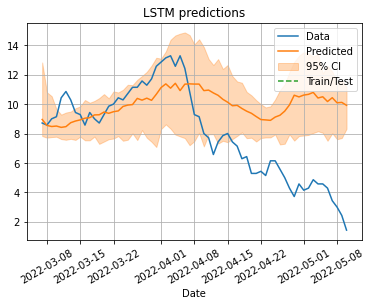

In [11]:
plot_df_predictions(df_pred)

### Function  `traininig_model()`:

This function will train a model with all the data available and will return the trained model and the history of the model.

This function has the following parameters: 

* `model`:A compiled LSTM model. 
* `target_name`: Name of the target column, this column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `predict_n`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `look_back`: Determines the number of the last days that will be used as features to forecast the next days. Type = `int`. Default = 14; 
* `batch`: . batch size for batch training. Type: `int`. Default = 1. 
* `epochs`: Number of epochs to train the model . Type: `int`. Default = 100. 
* `save`: If True, the trained model will be saved. Type: `boolean.` Default = False. 
* `path`: The path where the trained model will be saved. Type: `string`. Default = None. 
* `label`: The name used to save the trained model. The filename of the trained model is `{label}_{epochs}.h5`. Type: `string`. Default = `train_eval_region_name`.

Let's train a model with all the data available in the cell below:

In [16]:
model, hist = training_model(model, 
                   target_name,
                   df.iloc[-100:],
                   ini_date = '2020-08-01',
                   predict_n=14,
                   look_back=21,
                   batch  =1, 
                   epochs = 100,
                   path = 'saved_lstm_models', 
                   label = "train_region_name",
                   save = True)

Epoch 1/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0066 - accuracy: 0.0179 - mape: 23.0975 - mse: 0.0140 - msle: 0.0066 - val_loss: 0.0280 - val_accuracy: 0.0000e+00 - val_mape: 98.0229 - val_mse: 0.0507 - val_msle: 0.0280
Epoch 2/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0054 - accuracy: 0.0357 - mape: 21.4362 - mse: 0.0112 - msle: 0.0054 - val_loss: 0.0264 - val_accuracy: 0.1000 - val_mape: 95.9075 - val_mse: 0.0471 - val_msle: 0.0264
Epoch 3/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - mape: 21.9100 - mse: 0.0121 - msle: 0.0057 - val_loss: 0.0233 - val_accuracy: 0.0000e+00 - val_mape: 89.5945 - val_mse: 0.0411 - val_msle: 0.0233
Epoch 4/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0052 - accuracy: 0.0357 - mape: 20.5848 - mse: 0.0109 - msle: 0.0052 - val_loss: 0.0215 - val_accuracy: 0.2000 - val_mape: 85.3536 - val_mse: 0.0378 - val_msle: 0.0215
Epoch 5/100


56/56 [==============================] - 1s 19ms/step - loss: 0.0051 - accuracy: 0.1071 - mape: 20.2574 - mse: 0.0108 - msle: 0.0051 - val_loss: 0.0197 - val_accuracy: 0.5000 - val_mape: 81.4797 - val_mse: 0.0343 - val_msle: 0.0197
Epoch 35/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 0.0714 - mape: 18.5011 - mse: 0.0092 - msle: 0.0043 - val_loss: 0.0180 - val_accuracy: 0.3000 - val_mape: 77.9308 - val_mse: 0.0311 - val_msle: 0.0180
Epoch 36/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0035 - accuracy: 0.1429 - mape: 16.8466 - mse: 0.0075 - msle: 0.0035 - val_loss: 0.0159 - val_accuracy: 0.4000 - val_mape: 73.0294 - val_mse: 0.0272 - val_msle: 0.0159
Epoch 37/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0046 - accuracy: 0.1250 - mape: 19.0114 - mse: 0.0100 - msle: 0.0046 - val_loss: 0.0181 - val_accuracy: 0.3000 - val_mape: 78.3441 - val_mse: 0.0313 - val_msle: 0.0181
Epoch 38/100
56/56 [=============

56/56 [==============================] - 1s 19ms/step - loss: 0.0036 - accuracy: 0.2143 - mape: 16.5080 - mse: 0.0076 - msle: 0.0036 - val_loss: 0.0159 - val_accuracy: 0.2000 - val_mape: 72.9062 - val_mse: 0.0272 - val_msle: 0.0159
Epoch 68/100
56/56 [==============================] - 1s 20ms/step - loss: 0.0031 - accuracy: 0.1964 - mape: 15.2302 - mse: 0.0066 - msle: 0.0031 - val_loss: 0.0147 - val_accuracy: 0.3000 - val_mape: 69.6726 - val_mse: 0.0250 - val_msle: 0.0147
Epoch 69/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0031 - accuracy: 0.2321 - mape: 15.1468 - mse: 0.0065 - msle: 0.0031 - val_loss: 0.0144 - val_accuracy: 0.6000 - val_mape: 68.8727 - val_mse: 0.0245 - val_msle: 0.0144
Epoch 70/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0033 - accuracy: 0.1964 - mape: 16.1307 - mse: 0.0069 - msle: 0.0033 - val_loss: 0.0135 - val_accuracy: 0.4000 - val_mape: 67.0079 - val_mse: 0.0228 - val_msle: 0.0135
Epoch 71/100
56/56 [=============

### Function  `forecasting_model()`:

This function will use a saved model to make forecast. To make the forecast will be used the last observations of the dataframe `data`. This function will returns a Dataframe with the following columns: `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, and a datetime index.

This function has the following parameters: 

* `target_name`: Name of the target column, this column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `predict_n`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `look_back`: Determines the number of the last days that will be used as features to forecast the next days. Type = `int`. Default = 14; 
* `path`: The path where the trained model will be saved. Type: `string`. Default = None. 
* `label`: The name used to save the trained model. The filename of the trained model is `{label}_{epochs}.h5`. Type: `string`. Default = `train_eval_region_name`; 
* `uncertainty`: If True the confidence interval of the predictions is returned. Type: `boolean`. Default = True.

The return is:

* `df_for`: DataFrame with the forecasted values. T he data frame has the column `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, .The dataframe also have a datetime index. Type: `pandas Dataframe`.

Let's apply the forecast using the trained model saved in the `path = ''`.

In [17]:
%%time
df_for = forecasting_model(target_name,
                      df,
                      predict_n=14,
                      look_back=21,
                      path = 'saved_lstm_models', 
                      label = "train_region_name_100",
                      uncertainty = True)

1/1 [==============================] - 0s 15ms/step
CPU times: user 3.72 s, sys: 239 ms, total: 3.96 s
Wall time: 3.59 s


To plot the results obtained in the variable `df_for` let's use the function explained below:

### Function  `plot_forecast()`:

This function can be used to plot the data frame with the forecast obtained in the `rolling_forecast()` function. It's also necessary to provide a dataset with the data before the forecasted values (the same dataset provided in the `data` parameter of the `rolling_forecast()` function). The function has the following parameters: 

* `df`: It's a pandas Dataframe with the data used to make the forecast. Type = `pandas dataframe`. 
  
* `target_name`: Name of the target column forecasted. Type = `string`. 

* `df_for`: It's a dataframe  with the forecasted values, it's must have the following columns: lower, median, upper and a datetime index. Type = `pandas Dataframe`.  
                    
* `last_values`: Number of last values of the df show in the plot. Type = `int`. Default = 90. 
          
* `title`: This string is used as the plot's title. Type = `string`. Default = `Ngboost forecast`. 
 
* `save`: If true the plot is saved. Type = `boolean`. Default = False
    
* `filename`: Name of the png file where the plot is saved. Type = `string`. Default = `ngboost_forecast`.  
    
* `path`: Path where the figure must be saved. If None the figure is saved in the current directory. Type = `string|None`. Default = None. 

The return is None. 


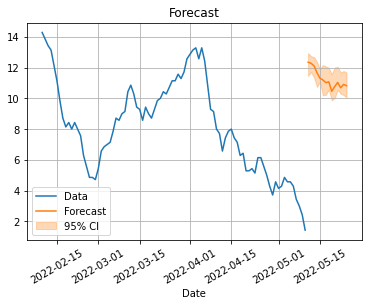

In [18]:
plot_forecast(df, target_name, df_for, last_values = 90, title = 'Forecast', save = False, filename = 'forecast', 
              path = None)